In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from tensorflow.keras.models import Sequential      #This allows appending layers to existing models
from tensorflow.keras.layers import Dense           #This allows defining the characteristics of a particular layer
from tensorflow.keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
from tensorflow.keras.regularizers import l2
tf.keras.backend.set_floatx('float64')

In [343]:
# Setting up data
Q = np.random.rand(6,6)
A = (Q.T + Q)/2 - np.eye(6)
A[0,0] += 3

# eigenvalues from max to min
eigenvalues, v = np.linalg.eig(A)
eig_vec_anal = v[:,0]
eig_val_anal = eigenvalues[0]
print(eig_vec_anal)
print(eig_val_anal)
print(eigenvalues)

[0.90708177 0.15109632 0.23371869 0.16161883 0.20751538 0.17482808]
3.4583209111738995
[ 3.45832091  0.59379017 -0.18341679 -0.68118804 -1.27950289 -1.07659957]


In [345]:
x = tf.reshape(tf.convert_to_tensor(eig_vec_anal), (-1, 1))
rhs1 = -x + ((tf.transpose(x) @ x)[0] * A + (1 - (tf.transpose(x) @ A @ x)[0]) * np.eye(6)) @ x
print(rhs1)

tf.Tensor(
[[3.33066907e-16]
 [2.22044605e-16]
 [5.27355937e-16]
 [1.11022302e-16]
 [1.94289029e-16]
 [2.49800181e-16]], shape=(6, 1), dtype=float64)


In [531]:
def loss(model, x, t):
    with tf.GradientTape() as tape_t:
        tape_t.watch([t])
        x_net = x + t / (t + 1) * model(tf.concat([x,t], 1))
    dx_dt = tape_t.gradient(x_net, t)

    x_net = tf.transpose(tf.reshape(x_net, (-1, 6)))
    Ax = A @ x_net
    xTx = tf.einsum("ij,ji->i", tf.transpose(x_net), x_net)
    xTAx = tf.einsum("ij,ji->i", tf.transpose(x_net), Ax)
    fx = xTx * Ax + (1 - xTAx) * x_net
    
    #rhs = -x + (tf.transpose(x) @ x @ A + (1 - tf.transpose(x) @ A @ x) @ np.eye(6)) @ x
    rhs = tf.reshape(tf.transpose(fx - x_net), (-1, 1))
    return tf.losses.mean_squared_error(zeros, dx_dt - rhs)

def train(model, optimizer, x, t):
    with tf.GradientTape() as tape:
        current_loss = loss(model, x, t)

    grads = tape.gradient(current_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

Nt = 30
Nx = 6
T_n = 5
x_np = np.random.rand(6,1)
#x_np = eig_vec_anal + x_np / 100
t_np = np.linspace(0, T_n, Nt)

X, T = np.meshgrid(x_np, t_np)

x = X.ravel()
t = T.ravel()

zeros = tf.reshape(tf.convert_to_tensor(np.zeros(x.shape)), shape=(-1,1))
x = tf.reshape(tf.convert_to_tensor(x, dtype=tf.dtypes.float64), shape=(-1,1))
t = tf.reshape(tf.convert_to_tensor(t), shape=(-1,1))

# Setting up model
model = Sequential()
#model.add(Dense(50, activation='sigmoid', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dense(50, activation='sigmoid'))
model.add(Dense(1, activation="linear"))
model.build(tf.concat([x,t], 1).shape)

eta = 0.00001
sgd = optimizers.SGD(lr=eta)
# Training model
#num_iter = 1
#for i in range(num_iter):
#    train(model, sgd, x, t)
    
# Output of model
g_dnn = x + t / T_n * model(tf.concat([x,t], 1))
G_dnn = np.array(g_dnn).reshape((Nt, Nx))

In [533]:
for i in range(100):
    train(model, sgd, x, t)
    
# Output of model
g_dnn = x + t / T_n * model(tf.concat([x,t], 1))
G_dnn = np.array(g_dnn).reshape((Nt, Nx))

In [534]:
eig_vec = np.array(G_dnn[-1])
eig_vec /= np.linalg.norm(eig_vec)
print(eig_vec)
print(f"{np.mean(A @ eig_vec / eig_vec):.3f} +- {np.std(A @ eig_vec / eig_vec):.3f}")
#print(A @ eig_vec / eig_vec)

[-0.58239717  0.4172033  -0.34685483 -0.40562915 -0.44810563  0.03336191]
-2.000 +- 6.570


In [432]:
# eigenvalues from max to min
eigenvalues, v = np.linalg.eig(A)
eig_vec_anal = v[:,0]
eig_val_anal = eigenvalues[0]
print(eig_vec_anal)
print(eig_val_anal)

[0.90708177 0.15109632 0.23371869 0.16161883 0.20751538 0.17482808]
3.4583209111738995


In [35]:
print(eigenvalues)
print(v)

[ 2.81331436  0.81630023 -1.5837526  -0.22169886 -0.62834936 -0.7823597 ]
[[ 0.85606148  0.4832934   0.05486941  0.1252647   0.11908508  0.02651567]
 [ 0.17748834 -0.37919208  0.19117362  0.45710149 -0.13930298 -0.74820907]
 [ 0.26744314 -0.60458105 -0.47222468  0.26462988  0.39518802  0.33727916]
 [ 0.14666665 -0.36624103  0.79905634 -0.27008675  0.30269604  0.20320831]
 [ 0.22822875 -0.25049329  0.08475942  0.08106214 -0.8393473   0.40854086]
 [ 0.30088426 -0.24544496 -0.3029367  -0.79108792 -0.11879003 -0.34281719]]


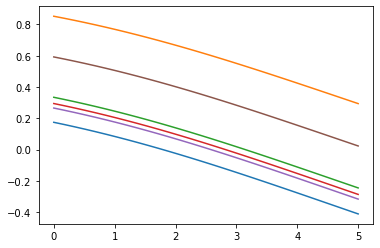

In [535]:
for i in range(Nx):
    plt.plot(t_np, G_dnn[:, i])